# Music Emotion Classifier using DEAM Dataset

This notebook implements an emotion classifier that predicts valence and arousal values from audio files in the DEAM (Database for Emotional Analysis in Music) dataset.

1. Install and import required libraries
2. Load and prepare the DEAM dataset
3. Extract mel-spectrograms from audio files
4. Build a CNN model to predict valence/arousal
5. Train and evaluate the model
6. Visualize the results and provide inference capability

## 1. Install and Import Required Libraries

In [1]:
# !pip install librosa matplotlib pandas numpy torch torchaudio scikit-learn tqdm

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import warnings
import ipywidgets
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Configuration Settings

In [ ]:
DEAM_DATASET_PATH = "./"  
ANNOTATIONS_FILE = os.path.join(DEAM_DATASET_PATH, "dataset", "annotations", 
                               "annotations averaged per song", "song_level", 
                               "static_annotations_averaged_songs_1_2000.csv")
AUDIO_DIR = os.path.join(DEAM_DATASET_PATH, "dataset", "MEMD_audio")
SEGMENT_DURATION = 30  #seconds
SAMPLE_RATE = 22050
N_MELS = 128
SPEC_WIDTH = 128  #target width for spectrograms
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


## 3. Dataset Class for DEAM

The following class handles loading audio files from the DEAM dataset and converting them to mel-spectrograms.

In [ ]:
class DEAMDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, segment_duration=30, sample_rate=22050, 
                 n_mels=128, spec_width=128, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.segment_duration = segment_duration
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.spec_width = spec_width
        self.transform = transform
        self.num_samples = segment_duration * sample_rate
        
        #filter annotations to only include songs with audio files
        self.annotations = self._filter_available_songs()
        
    def _filter_available_songs(self):
        available_songs = []
        missing_files = []

        print(f"Looking for audio files in: {self.audio_dir}")
        print(f"Total annotations before filtering: {len(self.annotations)}")
        
        # for debugging
        try:
            existing_files = os.listdir(self.audio_dir)
            print(f"Files in directory: {existing_files[:10]} (showing first 10)")
        except Exception as e:
            print(f"Error listing directory: {e}")
        
        for _, row in self.annotations.iterrows():
            #extract the integer part before any decimal point
            try:
                song_id = str(row['song_id']).split('.')[0]
                file_path = os.path.join(self.audio_dir, f"{song_id}.mp3")
                
                if os.path.exists(file_path):
                    available_songs.append(row)
                else:
                    missing_files.append((song_id, file_path))
            except Exception as e:
                print(f"Error processing song_id {row['song_id']}: {e}")

        if len(available_songs) == 0:
            print("No audio files found! Here are the first 5 missing files:")
            for song_id, path in missing_files[:5]:
                print(f"- Song ID: {song_id}, Path: {path}")
        else:
            print(f"Found {len(available_songs)} matching audio files out of {len(self.annotations)} annotations")

        return pd.DataFrame(available_songs)
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        song_id = str(self.annotations.iloc[idx]['song_id']).split('.')[0]
        file_path = os.path.join(self.audio_dir, f"{song_id}.mp3")
        
        #extract valence and arousal labels
        valence = self.annotations.iloc[idx]['valence_mean']
        arousal = self.annotations.iloc[idx]['arousal_mean']
        
        #normalize values from 1-9 scale to 0-1 scale
        valence = (valence - 1) / 8.0
        arousal = (arousal - 1) / 8.0
        
        labels = torch.tensor([valence, arousal], dtype=torch.float32)
        
        #load audio and convert to mel-spectrogram
        try:
            #load audio file using librosa
            y, sr = librosa.load(file_path, sr=self.sample_rate, duration=self.segment_duration)
            
            #if audio is shorter than segment_duration, pad with zeros
            if len(y) < self.num_samples:
                y = np.pad(y, (0, self.num_samples - len(y)), 'constant')
            
            #extract mel-spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=y, 
                sr=sr, 
                n_mels=self.n_mels
            )
            
            #convert to decibels
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            #normalize
            mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
            
            #resize to target width
            if mel_spec_norm.shape[1] > self.spec_width:
                #take the first spec_width frames
                mel_spec_norm = mel_spec_norm[:, :self.spec_width]
            elif mel_spec_norm.shape[1] < self.spec_width:
                #pad with zeros
                padding = np.zeros((self.n_mels, self.spec_width - mel_spec_norm.shape[1]))
                mel_spec_norm = np.hstack((mel_spec_norm, padding))
            
            mel_spec_tensor = torch.tensor(mel_spec_norm, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
            
            if self.transform:
                mel_spec_tensor = self.transform(mel_spec_tensor)
            
            return mel_spec_tensor, labels
        
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            #return a placeholder tensor if there's an error
            placeholder = torch.zeros((1, self.n_mels, self.spec_width), dtype=torch.float32)
            return placeholder, labels

## 4. Load the Dataset and Visualize Examples

In [ ]:
if os.path.exists(ANNOTATIONS_FILE):
    print(f"Annotations file found: {ANNOTATIONS_FILE}")
    df = pd.read_csv(ANNOTATIONS_FILE)
    print(f"Loaded {len(df)} annotations, sample: {df.head(3)}")
else:
    print(f"Annotations file not found: {ANNOTATIONS_FILE}")

Annotations file found: ./dataset/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv
Loaded 1744 annotations, sample:    song_id  valence_mean  valence_std  arousal_mean  arousal_std
0        2           3.1         0.94           3.0         0.63
1        3           3.5         1.75           3.3         1.62
2        4           5.7         1.42           5.5         1.63


In [ ]:
dataset = DEAMDataset(
    annotations_file=ANNOTATIONS_FILE,
    audio_dir=AUDIO_DIR,
    segment_duration=SEGMENT_DURATION,
    sample_rate=SAMPLE_RATE,
    n_mels=N_MELS,
    spec_width=SPEC_WIDTH
)

print(f"Dataset size: {len(dataset)}")

Looking for audio files in: ./dataset/MEMD_audio
Total annotations before filtering: 1744
Files in directory: ['323.mp3:Zone.Identifier', '1203.mp3', '1154.mp3:Zone.Identifier', '1141.mp3', '1698.mp3:Zone.Identifier', '1789.mp3:Zone.Identifier', '1511.mp3', '1762.mp3', '710.mp3', '148.mp3:Zone.Identifier'] (showing first 10)
Found 1744 matching audio files out of 1744 annotations
Dataset size: 1744


### Visualize Example Mel-Spectrograms

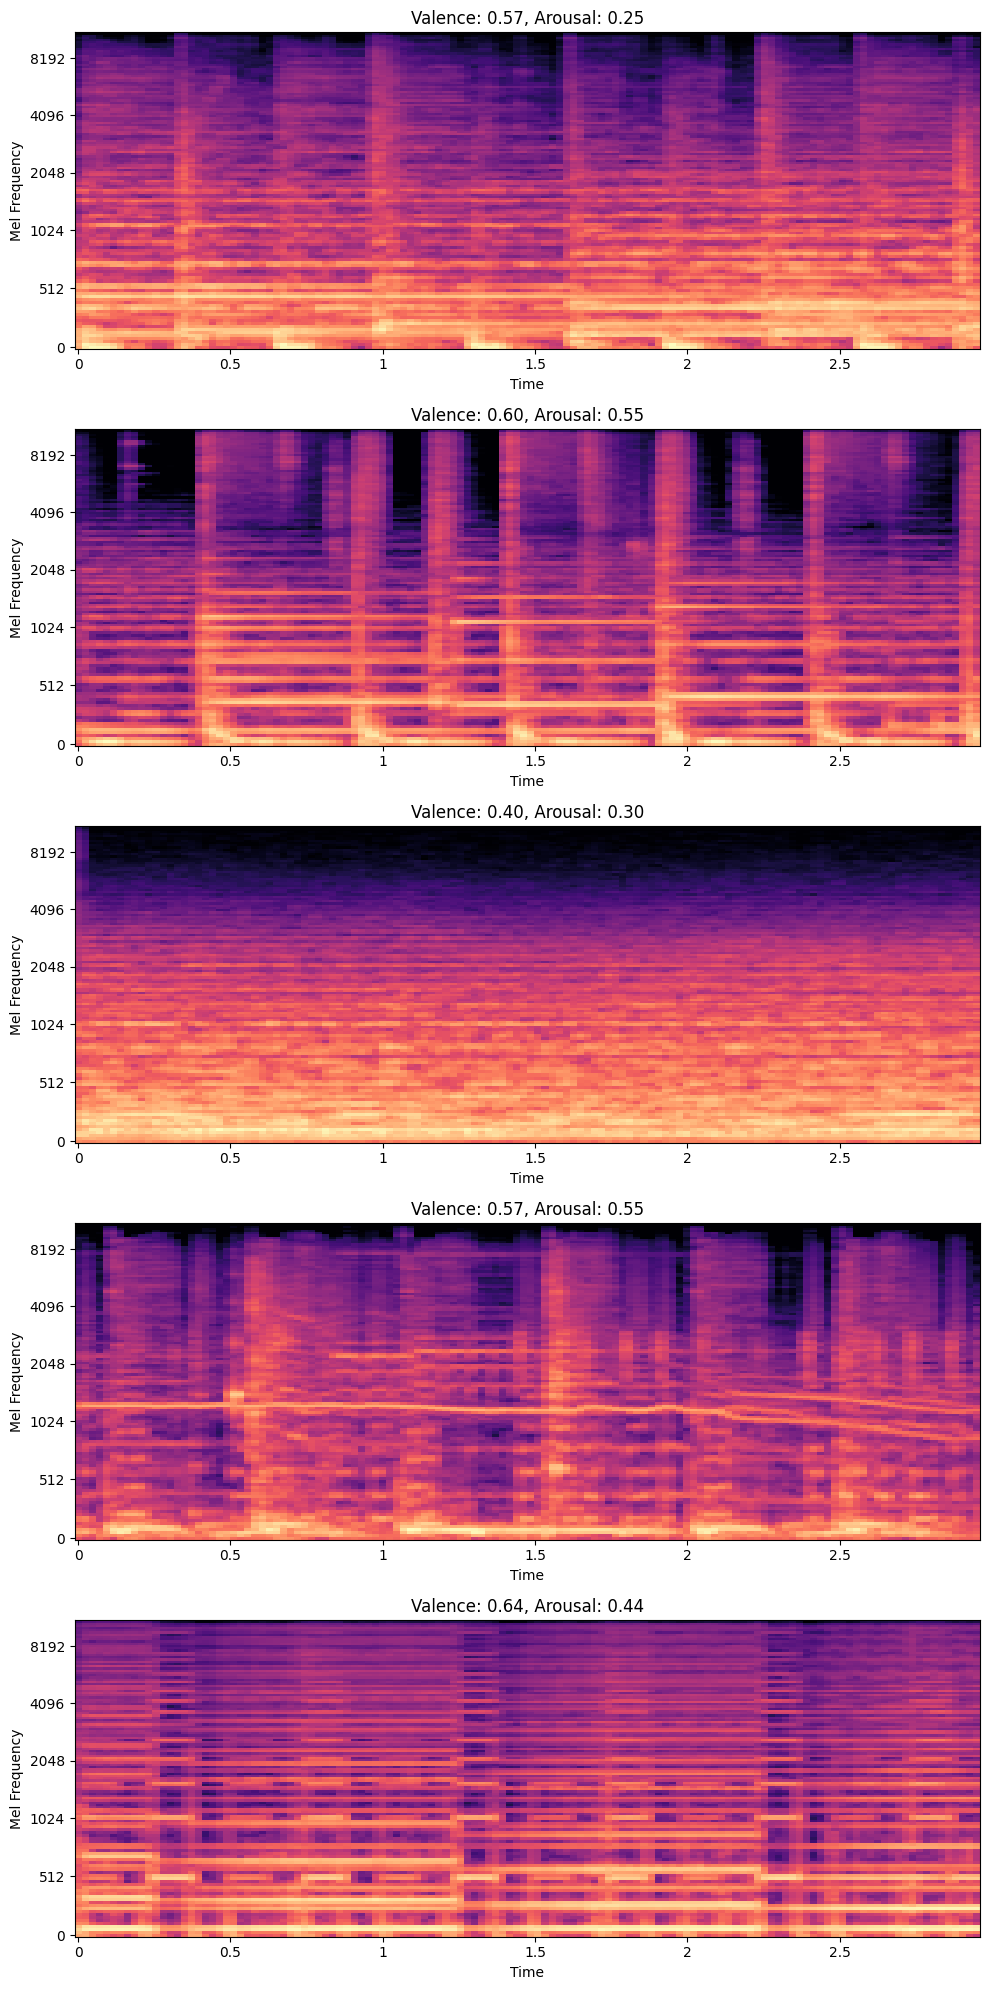

In [ ]:
def visualize_spectrograms(dataset, num_examples=5):
    fig, axes = plt.subplots(num_examples, 1, figsize=(10, 4*num_examples))
    
    for i in range(num_examples):
        idx = np.random.randint(0, len(dataset))
        mel_spec, labels = dataset[idx]
        
        mel_spec = mel_spec.squeeze(0).numpy()  #remove channel dimension
        
        if num_examples > 1:
            ax = axes[i]
        else:
            ax = axes
            
        librosa.display.specshow(mel_spec, y_axis='mel', x_axis='time', ax=ax)
        ax.set_title(f"Valence: {labels[0]:.2f}, Arousal: {labels[1]:.2f}")
        ax.set_ylabel('Mel Frequency')
        
    plt.tight_layout()
    plt.show()

visualize_spectrograms(dataset)

### Visualize Emotion Distribution

Loading samples for visualization:   0%|          | 0/200 [00:00<?, ?it/s]

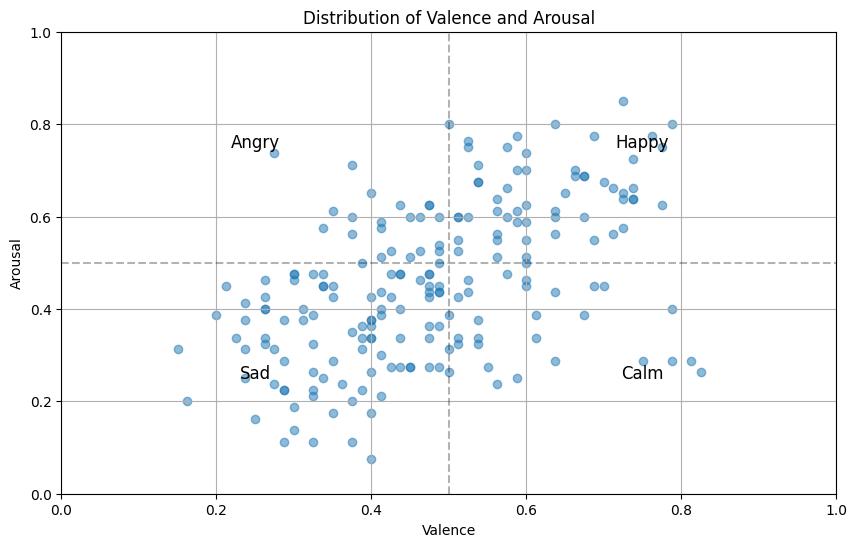

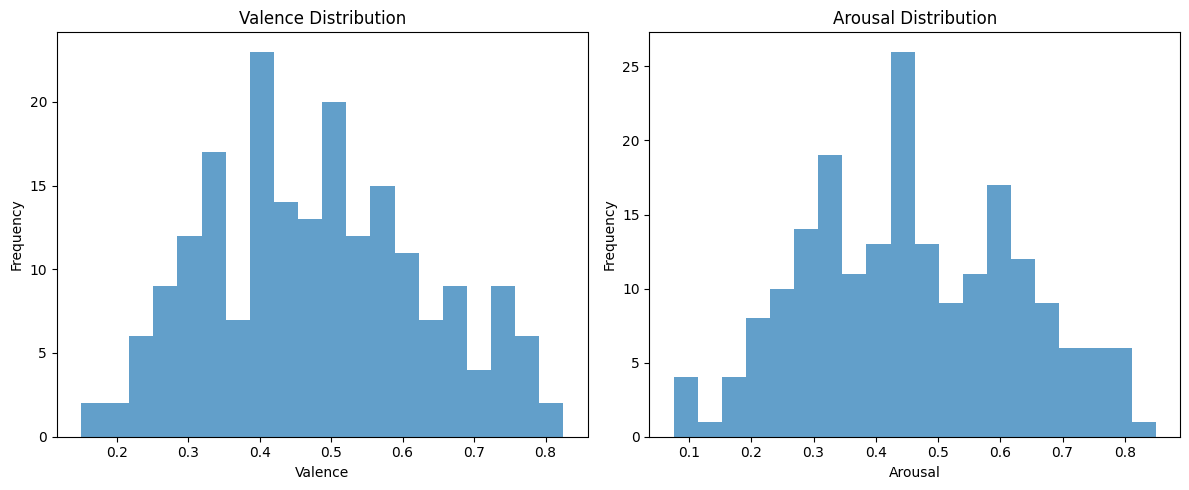

In [ ]:
def visualize_emotion_distribution(dataset):
    valence = []
    arousal = []
    
    #sample 200 items to speed up visualization
    sample_size = min(200, len(dataset))
    indices = np.random.choice(len(dataset), sample_size, replace=False)
    
    for i in tqdm(indices, desc="Loading samples for visualization"):
        _, labels = dataset[i]
        valence.append(labels[0].item())
        arousal.append(labels[1].item())
    
    #ploting valence-arousal scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(valence, arousal, alpha=0.5)
    plt.title('Distribution of Valence and Arousal')
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    #adding emotion quadrants
    plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0.5, color='k', linestyle='--', alpha=0.3)
    plt.text(0.25, 0.75, 'Angry', fontsize=12, ha='center')
    plt.text(0.75, 0.75, 'Happy', fontsize=12, ha='center')
    plt.text(0.25, 0.25, 'Sad', fontsize=12, ha='center')
    plt.text(0.75, 0.25, 'Calm', fontsize=12, ha='center')
    
    plt.show()
    
    #plot histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.hist(valence, bins=20, alpha=0.7)
    ax1.set_title('Valence Distribution')
    ax1.set_xlabel('Valence')
    ax1.set_ylabel('Frequency')
    
    ax2.hist(arousal, bins=20, alpha=0.7)
    ax2.set_title('Arousal Distribution')
    ax2.set_xlabel('Arousal')
    ax2.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

visualize_emotion_distribution(dataset)

## 5. Define the CNN Model

In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  #assuming input size is 128x128 after pooling
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)  #output: valence and arousal
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  #for 0-1 output range
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
        x = x.view(-1, 128 * 8 * 8)  #flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))  #use sigmoid to get values in [0,1]
        
        return x

#initialize model
model = EmotionCNN().to(DEVICE)
print(model)

EmotionCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): Re

## 6. Split Dataset and Create Data Loaders

In [ ]:
#split dataset into train, validation, and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 of total

print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")

#create data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Train size: 1046, Val size: 349, Test size: 349


## 7. Training Functions

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        #training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        #validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    return train_losses, val_losses

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## 8. Define Loss Function and Optimizer

In [ ]:
#define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 9. Train the Model

Note: This cell may take a long time to run depending on your dataset size and hardware.

Epoch 1/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 0.0325, Val Loss: 0.0169


Epoch 2/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 0.0179, Val Loss: 0.0150


Epoch 3/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 0.0177, Val Loss: 0.0153


Epoch 4/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 0.0166, Val Loss: 0.0164


Epoch 5/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.0163, Val Loss: 0.0178


Epoch 6/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.0168, Val Loss: 0.0144


Epoch 7/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 0.0169, Val Loss: 0.0151


Epoch 8/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 0.0158, Val Loss: 0.0187


Epoch 9/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 0.0152, Val Loss: 0.0132


Epoch 10/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.0148, Val Loss: 0.0152


Epoch 11/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.0151, Val Loss: 0.0164


Epoch 12/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.0154, Val Loss: 0.0130


Epoch 13/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.0146, Val Loss: 0.0143


Epoch 14/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 0.0142, Val Loss: 0.0134


Epoch 15/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15/20 - Train Loss: 0.0140, Val Loss: 0.0126


Epoch 16/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16/20 - Train Loss: 0.0140, Val Loss: 0.0145


Epoch 17/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17/20 - Train Loss: 0.0140, Val Loss: 0.0144


Epoch 18/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18/20 - Train Loss: 0.0140, Val Loss: 0.0137


Epoch 19/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19/20 - Train Loss: 0.0138, Val Loss: 0.0146


Epoch 20/20 - Training:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20/20 - Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20/20 - Train Loss: 0.0138, Val Loss: 0.0129


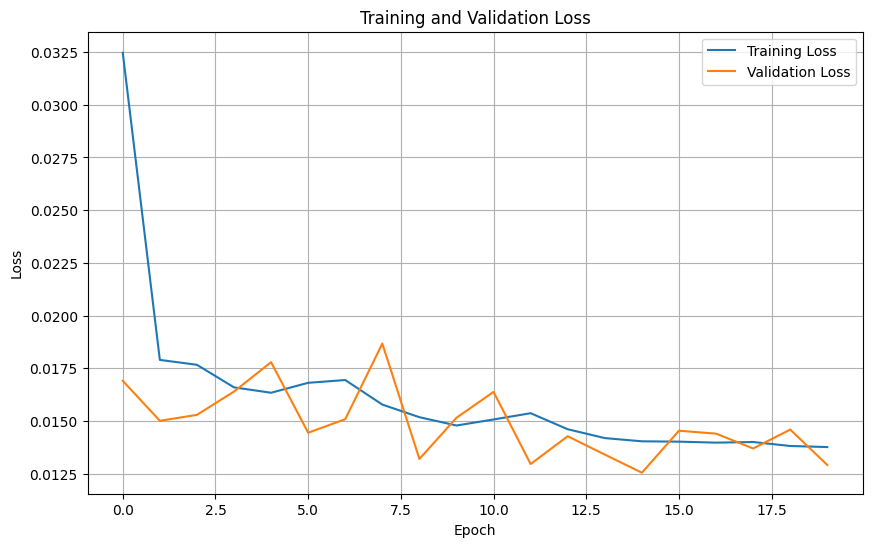

In [ ]:

# Train model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE
)

# Plot training history
plot_training_history(train_losses, val_losses)

## 10. Evaluate Model Performance

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Valence RMSE: 0.1072
Arousal RMSE: 0.1207


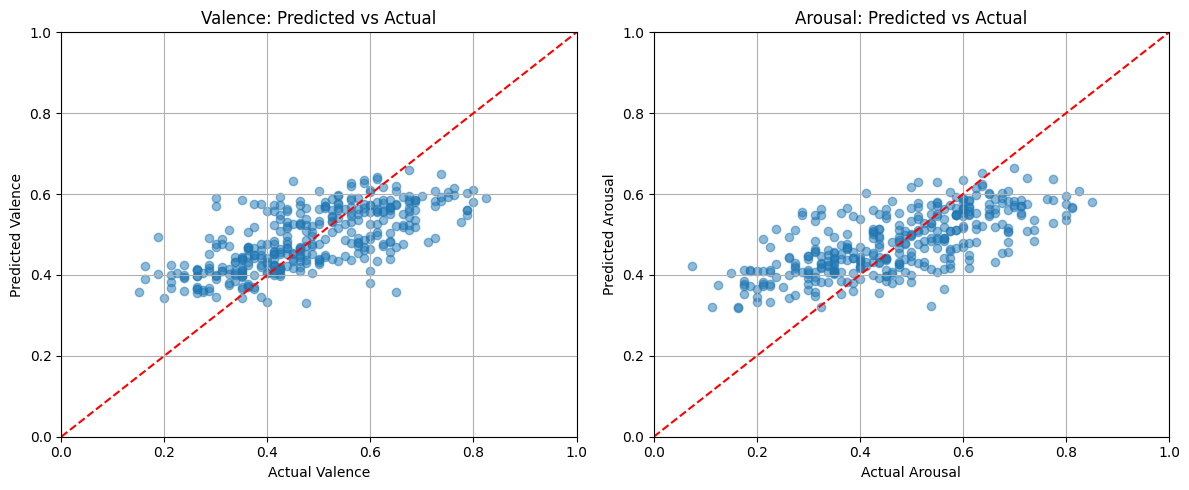

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    #calculating RMSE for valence and arousal
    valence_rmse = np.sqrt(mean_squared_error(all_labels[:, 0], all_preds[:, 0]))
    arousal_rmse = np.sqrt(mean_squared_error(all_labels[:, 1], all_preds[:, 1]))
    
    print(f"Valence RMSE: {valence_rmse:.4f}")
    print(f"Arousal RMSE: {arousal_rmse:.4f}")
    
    #creating a scatter plot of predicted vs actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.scatter(all_labels[:, 0], all_preds[:, 0], alpha=0.5)
    ax1.plot([0, 1], [0, 1], 'r--')  # Perfect prediction line
    ax1.set_title('Valence: Predicted vs Actual')
    ax1.set_xlabel('Actual Valence')
    ax1.set_ylabel('Predicted Valence')
    ax1.grid(True)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    ax2.scatter(all_labels[:, 1], all_preds[:, 1], alpha=0.5)
    ax2.plot([0, 1], [0, 1], 'r--')  #perfect prediction line
    ax2.set_title('Arousal: Predicted vs Actual')
    ax2.set_xlabel('Actual Arousal')
    ax2.set_ylabel('Predicted Arousal')
    ax2.grid(True)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return valence_rmse, arousal_rmse, all_preds, all_labels

# Evaluate model
valence_rmse, arousal_rmse, predictions, actual = evaluate_model(model, test_loader, DEVICE)

## 11. Save the Model

In [19]:
# Save model
torch.save(model.state_dict(), 'deam_emotion_model.pth')
print("Model saved as 'deam_emotion_model.pth'")

Model saved as 'deam_emotion_model.pth'


## 12. Inference Function for New Audio Files

In [20]:
def inference(model, audio_file, device):
    # Load audio file
    y, sr = librosa.load(audio_file, sr=SAMPLE_RATE, duration=SEGMENT_DURATION)
    
    # If audio is shorter than segment_duration, pad with zeros
    if len(y) < SEGMENT_DURATION * SAMPLE_RATE:
        y = np.pad(y, (0, SEGMENT_DURATION * SAMPLE_RATE - len(y)), 'constant')
    
    # Extract mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    
    # Convert to decibels
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Normalize
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    
    # Resize to target width
    if mel_spec_norm.shape[1] > SPEC_WIDTH:
        mel_spec_norm = mel_spec_norm[:, :SPEC_WIDTH]
    elif mel_spec_norm.shape[1] < SPEC_WIDTH:
        padding = np.zeros((N_MELS, SPEC_WIDTH - mel_spec_norm.shape[1]))
        mel_spec_norm = np.hstack((mel_spec_norm, padding))
    
    # Convert to tensor
    mel_spec_tensor = torch.tensor(mel_spec_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    
    # Move to device
    mel_spec_tensor = mel_spec_tensor.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        prediction = model(mel_spec_tensor)
    
    valence = prediction[0][0].item()
    arousal = prediction[0][1].item()
    
    # Map to emotion categories (optional)
    emotion_map = {
        (True, True): "Happy",     # High valence, high arousal
        (True, False): "Calm",     # High valence, low arousal
        (False, True): "Angry",    # Low valence, high arousal
        (False, False): "Sad"      # Low valence, low arousal
    }
    
    emotion = emotion_map[(valence > 0.5, arousal > 0.5)]
    
    # Visualize the mel-spectrogram and prediction
    plt.figure(figsize=(12, 6))
    
    # Plot mel-spectrogram
    plt.subplot(1, 2, 1)
    librosa.display.specshow(mel_spec_norm, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    
    # Plot prediction in valence-arousal space
    plt.subplot(1, 2, 2)
    plt.scatter(valence, arousal, color='red', s=100, marker='x')
    plt.title(f'Predicted Emotion: {emotion}')
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    
    # Add emotion quadrants
    plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0.5, color='k', linestyle='--', alpha=0.3)
    plt.text(0.25, 0.75, 'Angry', fontsize=12, ha='center')
    plt.text(0.75, 0.75, 'Happy', fontsize=12, ha='center')
    plt.text(0.25, 0.25, 'Sad', fontsize=12, ha='center')
    plt.text(0.75, 0.25, 'Calm', fontsize=12, ha='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Valence: {valence:.4f}")
    print(f"Arousal: {arousal:.4f}")
    print(f"Emotion Category: {emotion}")
    
    return valence, arousal, emotion

def predict_emotion(audio_file, model_path='deam_emotion_model.pth'):
    """
    Predict emotion (valence, arousal) for a new audio file
    
    Parameters:
    - audio_file: path to the audio file
    - model_path: path to the saved model
    
    Returns:
    - valence: predicted valence (0-1)
    - arousal: predicted arousal (0-1)
    - emotion: mapped emotion category
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    model = EmotionCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Make prediction
    return inference(model, audio_file, device)

## 13. Test Inference on Sample Audio Files

Let's test our model on some sample files from the test set.

Found 3 audio files in ./test_audio


------- Processing: HappyPianoOnTheRun.mp3 -------


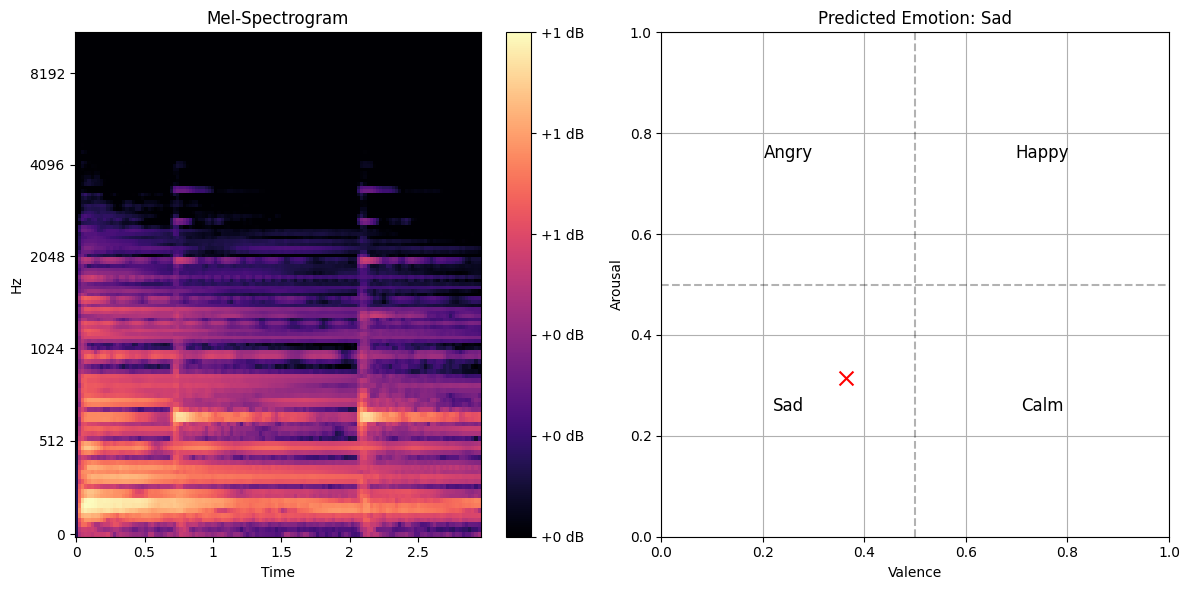

Valence: 0.3629
Arousal: 0.3154
Emotion Category: Sad
Predicted values:
  Valence: 0.3629
  Arousal: 0.3154
  Emotion: Sad


------- Processing: SaxPadHouse.mp3 -------


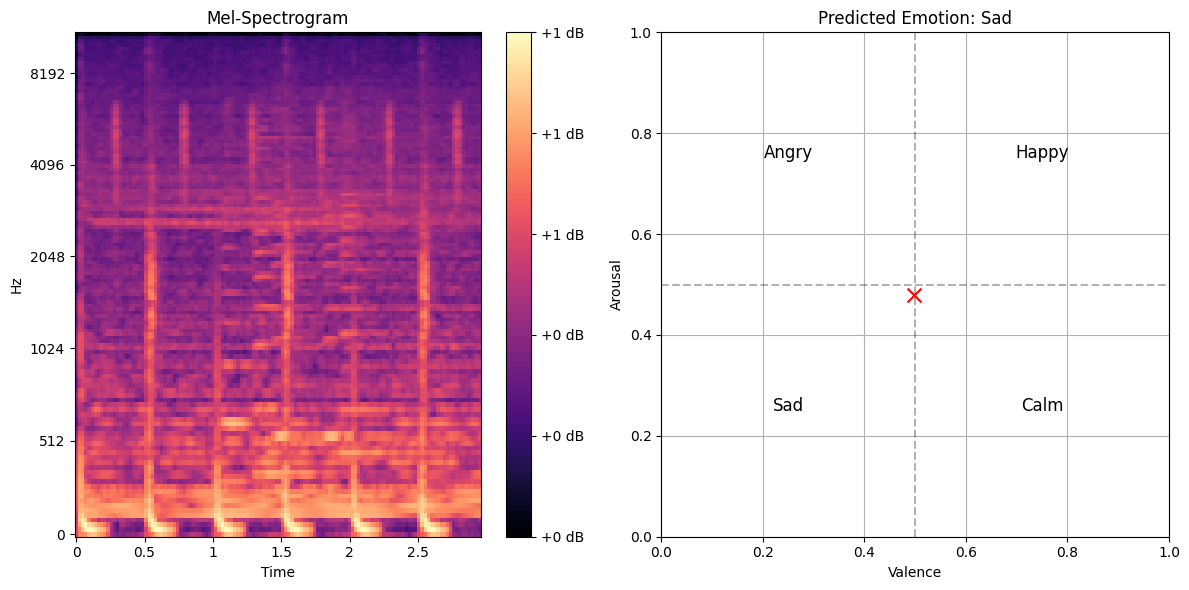

Valence: 0.4978
Arousal: 0.4785
Emotion Category: Sad
Predicted values:
  Valence: 0.4978
  Arousal: 0.4785
  Emotion: Sad


------- Processing: Ringtone Sound Effect.mp3 -------


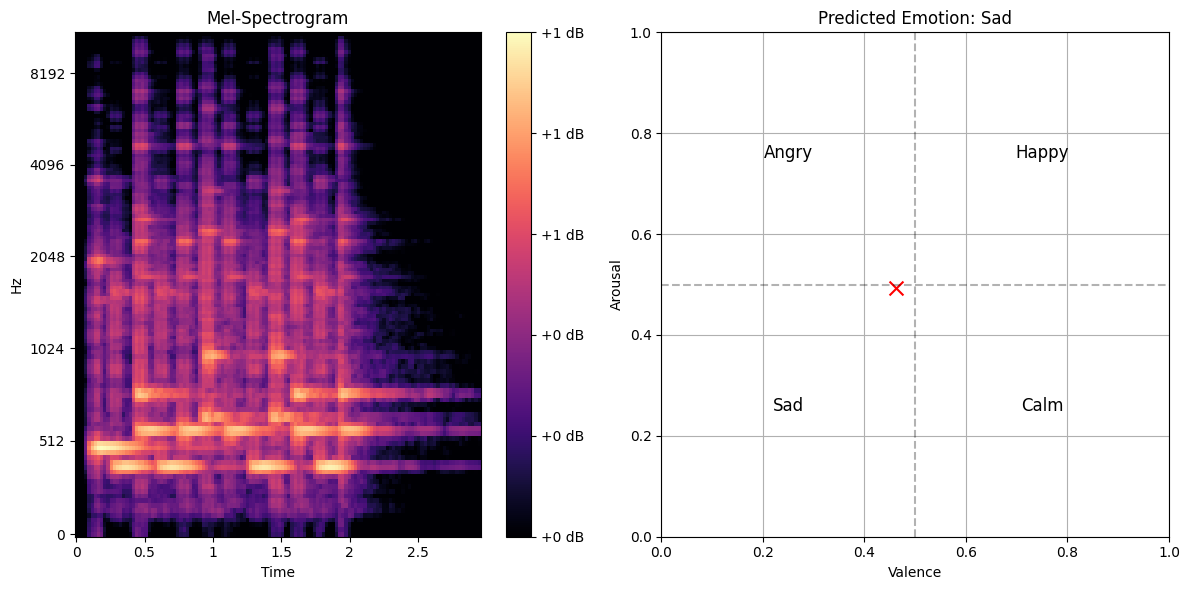

Valence: 0.4618
Arousal: 0.4925
Emotion Category: Sad
Predicted values:
  Valence: 0.4618
  Arousal: 0.4925
  Emotion: Sad


In [25]:
# Test inference on multiple audio files from a test folder
test_folder = "./test_audio"  # Update this path to your test audio folder

# Check if test folder exists
if not os.path.exists(test_folder):
    print(f"Test folder {test_folder} not found. Creating it...")
    os.makedirs(test_folder)
    print(f"Please place audio files in {test_folder} and run this cell again.")
else:
    # Get all audio files in the test folder
    audio_files = [f for f in os.listdir(test_folder) if f.endswith(('.mp3', '.wav', '.ogg'))]
    
    if len(audio_files) == 0:
        print(f"No audio files found in {test_folder}. Please add some audio files.")
    else:
        print(f"Found {len(audio_files)} audio files in {test_folder}")
        
        # Process each audio file
        for audio_file in audio_files:
            file_path = os.path.join(test_folder, audio_file)
            print(f"\n\n------- Processing: {audio_file} -------")
            
            try:
                # Run inference
                valence, arousal, emotion = inference(model, file_path, DEVICE)
                
                # Print results
                print(f"Predicted values:")
                print(f"  Valence: {valence:.4f}")
                print(f"  Arousal: {arousal:.4f}")
                print(f"  Emotion: {emotion}")
                
            except Exception as e:
                print(f"Error processing {audio_file}: {str(e)}")

## 14. Extended Analysis: Explore Model Performance

Let's examine the prediction errors across the test set to gain insights into the model's performance.

Valence Error Statistics:
Mean: 0.0859
Median: 0.0738
Min: 0.0002
Max: 0.3075
95th Percentile: 0.2106

Arousal Error Statistics:
Mean: 0.0975
Median: 0.0824
Min: 0.0001
Max: 0.3464
95th Percentile: 0.2351


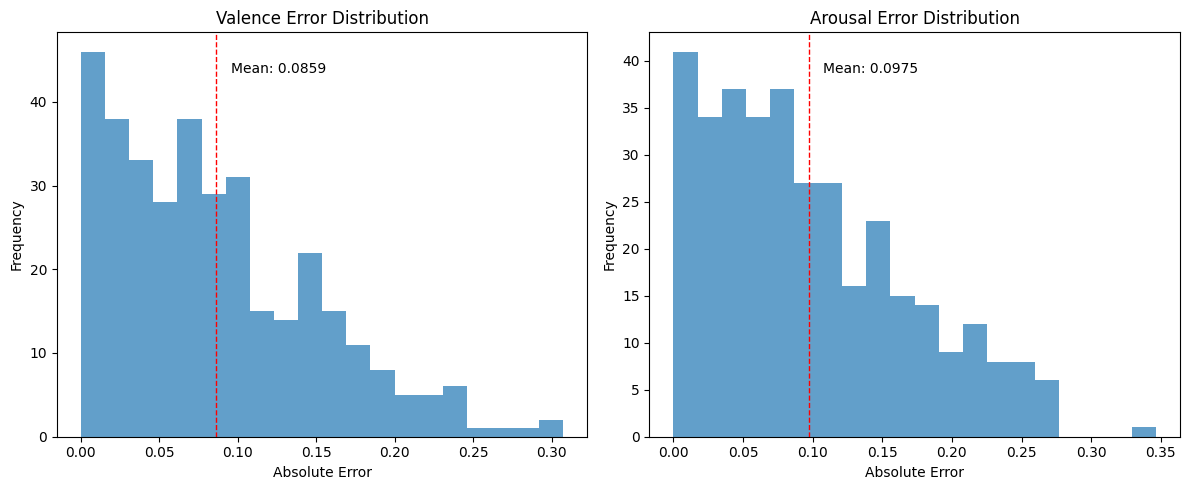


Valence prediction bias: 0.0079 (positive means model predicts higher than actual)
Arousal prediction bias: 0.0108 (positive means model predicts higher than actual)


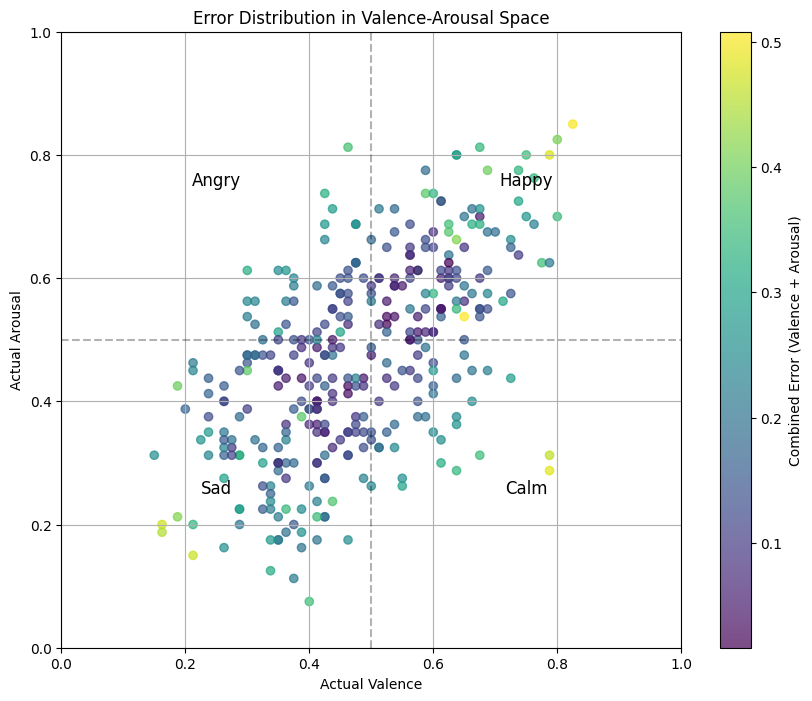

In [22]:
def analyze_predictions(predictions, actual):
    # Calculate errors
    valence_errors = np.abs(predictions[:, 0] - actual[:, 0])
    arousal_errors = np.abs(predictions[:, 1] - actual[:, 1])
    
    # Summary statistics
    print("Valence Error Statistics:")
    print(f"Mean: {np.mean(valence_errors):.4f}")
    print(f"Median: {np.median(valence_errors):.4f}")
    print(f"Min: {np.min(valence_errors):.4f}")
    print(f"Max: {np.max(valence_errors):.4f}")
    print(f"95th Percentile: {np.percentile(valence_errors, 95):.4f}")
    
    print("\nArousal Error Statistics:")
    print(f"Mean: {np.mean(arousal_errors):.4f}")
    print(f"Median: {np.median(arousal_errors):.4f}")
    print(f"Min: {np.min(arousal_errors):.4f}")
    print(f"Max: {np.max(arousal_errors):.4f}")
    print(f"95th Percentile: {np.percentile(arousal_errors, 95):.4f}")
    
    # Plot error histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.hist(valence_errors, bins=20, alpha=0.7)
    ax1.set_title('Valence Error Distribution')
    ax1.set_xlabel('Absolute Error')
    ax1.set_ylabel('Frequency')
    ax1.axvline(np.mean(valence_errors), color='r', linestyle='dashed', linewidth=1)
    ax1.text(np.mean(valence_errors) + 0.01, ax1.get_ylim()[1] * 0.9, f'Mean: {np.mean(valence_errors):.4f}')
    
    ax2.hist(arousal_errors, bins=20, alpha=0.7)
    ax2.set_title('Arousal Error Distribution')
    ax2.set_xlabel('Absolute Error')
    ax2.set_ylabel('Frequency')
    ax2.axvline(np.mean(arousal_errors), color='r', linestyle='dashed', linewidth=1)
    ax2.text(np.mean(arousal_errors) + 0.01, ax2.get_ylim()[1] * 0.9, f'Mean: {np.mean(arousal_errors):.4f}')
    
    plt.tight_layout()
    plt.show()
    
    # Check if there's bias in the predictions
    valence_bias = np.mean(predictions[:, 0] - actual[:, 0])
    arousal_bias = np.mean(predictions[:, 1] - actual[:, 1])
    
    print(f"\nValence prediction bias: {valence_bias:.4f} (positive means model predicts higher than actual)")
    print(f"Arousal prediction bias: {arousal_bias:.4f} (positive means model predicts higher than actual)")
    
    # Plot error heat map in valence-arousal space
    plt.figure(figsize=(10, 8))
    
    # Calculate total error for each point
    total_errors = valence_errors + arousal_errors
    
    plt.scatter(actual[:, 0], actual[:, 1], c=total_errors, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Combined Error (Valence + Arousal)')
    plt.title('Error Distribution in Valence-Arousal Space')
    plt.xlabel('Actual Valence')
    plt.ylabel('Actual Arousal')
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Add emotion quadrants
    plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0.5, color='k', linestyle='--', alpha=0.3)
    plt.text(0.25, 0.75, 'Angry', fontsize=12, ha='center')
    plt.text(0.75, 0.75, 'Happy', fontsize=12, ha='center')
    plt.text(0.25, 0.25, 'Sad', fontsize=12, ha='center')
    plt.text(0.75, 0.25, 'Calm', fontsize=12, ha='center')
    
    plt.show()

# Analyze predictions if we have them from evaluation
if 'predictions' in locals() and 'actual' in locals():
    analyze_predictions(predictions, actual)

## 15. Optional: Categorical Emotion Classification

Let's convert our regression model to a categorical emotion classifier by binning the valence and arousal values.

In [ ]:
def evaluate_categorical_emotions(predictions, actual):
    # Define emotion categories based on valence/arousal quadrants
    # High valence, high arousal = Happy
    # High valence, low arousal = Calm
    # Low valence, high arousal = Angry
    # Low valence, low arousal = Sad
    
    # Convert predictions to categories
    pred_categories = []
    for v, a in predictions:
        if v > 0.5 and a > 0.5:
            pred_categories.append("Happy")
        elif v > 0.5 and a <= 0.5:
            pred_categories.append("Calm")
        elif v <= 0.5 and a > 0.5:
            pred_categories.append("Angry")
        else:
            pred_categories.append("Sad")
    
    # Convert actual values to categories
    actual_categories = []
    for v, a in actual:
        if v > 0.5 and a > 0.5:
            actual_categories.append("Happy")
        elif v > 0.5 and a <= 0.5:
            actual_categories.append("Calm")
        elif v <= 0.5 and a > 0.5:
            actual_categories.append("Angry")
        else:
            actual_categories.append("Sad")
    
    # Calculate accuracy
    correct = sum(1 for p, a in zip(pred_categories, actual_categories) if p == a)
    accuracy = correct / len(pred_categories)
    
    print(f"Categorical Emotion Classification Accuracy: {accuracy:.4f}")
    
    # Create confusion matrix
    categories = ["Happy", "Calm", "Angry", "Sad"]
    confusion = np.zeros((4, 4), dtype=int)
    
    for p, a in zip(pred_categories, actual_categories):
        p_idx = categories.index(p)
        a_idx = categories.index(a)
        confusion[a_idx, p_idx] += 1
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    tick_marks = np.arange(len(categories))
    plt.xticks(tick_marks, categories, rotation=45)
    plt.yticks(tick_marks, categories)
    
    # Add text annotations
    thresh = confusion.max() / 2
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            plt.text(j, i, format(confusion[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if confusion[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Calculate per-class metrics
    print("\nPer-class performance:")
    for i, category in enumerate(categories):
        # True positives are diagonal elements
        tp = confusion[i, i]
        # False negatives are other elements in row i
        fn = sum(confusion[i, :]) - tp
        # False positives are other elements in column i
        fp = sum(confusion[:, i]) - tp
        
        # Calculate precision, recall, and F1-score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{category}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1:.4f}")
    
    return accuracy, confusion

# Evaluate categorical emotions if we have predictions
if 'predictions' in locals() and 'actual' in locals():
    evaluate_categorical_emotions(predictions, actual)

## 16. Further Model Improvements

Here are some ideas to improve the model's performance:

1. Data augmentation techniques for audio:
   - Time stretching
   - Pitch shifting
   - Adding noise
   - Time masking
   - Frequency masking

2. Feature engineering:
   - Use additional audio features (chroma, tempo, rhythm patterns)
   - Try different spectrogram types (constant-Q transform)
   - Extract features at different time scales

3. Model architecture improvements:
   - Try different CNN architectures (ResNet, VGG)
   - Add recurrent layers (LSTM, GRU) to capture temporal information
   - Use transfer learning from pre-trained audio models
   - Experiment with attention mechanisms

Let's implement a simple data augmentation function to show how it could be done:

In [ ]:
def audio_augmentation(y, sr):
    """
    Apply random augmentations to audio signal
    """
    # Randomly choose which augmentations to apply
    augmentations = np.random.choice([True, False], size=3)
    
    # 1. Time stretching
    if augmentations[0]:
        stretch_factor = np.random.uniform(0.8, 1.2)
        y = librosa.effects.time_stretch(y, rate=stretch_factor)
    
    # 2. Pitch shifting
    if augmentations[1]:
        n_steps = np.random.randint(-4, 5)  # Shift by -4 to +4 semitones
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    
    # 3. Adding noise
    if augmentations[2]:
        noise_factor = np.random.uniform(0.001, 0.01)
        noise = np.random.randn(len(y))
        y = y + noise_factor * noise
    
    return y

# Example of using augmentation in the dataset class
# Add this to __getitem__ in DEAMDataset before extracting mel spectrogram:
#
# if self.transform:  # Use transform flag to enable/disable augmentation
#     y = audio_augmentation(y, sr)

# To demonstrate, let's visualize an example of augmented audio
if os.path.exists(test_file):
    # Original audio
    y_orig, sr = librosa.load(test_file, sr=SAMPLE_RATE, duration=SEGMENT_DURATION)
    
    # Augmented audio
    y_aug = audio_augmentation(y_orig.copy(), sr)
    
    # Plot waveforms
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 2, 1)
    plt.plot(y_orig)
    plt.title('Original Waveform')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 2, 2)
    plt.plot(y_aug)
    plt.title('Augmented Waveform')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    # Extract and plot spectrograms
    mel_orig = librosa.feature.melspectrogram(y=y_orig, sr=sr, n_mels=N_MELS)
    mel_orig_db = librosa.power_to_db(mel_orig, ref=np.max)
    
    mel_aug = librosa.feature.melspectrogram(y=y_aug, sr=sr, n_mels=N_MELS)
    mel_aug_db = librosa.power_to_db(mel_aug, ref=np.max)
    
    plt.subplot(2, 2, 3)
    librosa.display.specshow(mel_orig_db, y_axis='mel', x_axis='time')
    plt.title('Original Mel-Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(2, 2, 4)
    librosa.display.specshow(mel_aug_db, y_axis='mel', x_axis='time')
    plt.title('Augmented Mel-Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

## 17. Conclusion

In this notebook, we've built a complete pipeline for music emotion recognition using the DEAM dataset:

1. Loaded and preprocessed audio files from the DEAM dataset
2. Extracted mel-spectrograms as features
3. Built and trained a CNN model to predict valence and arousal
4. Evaluated the model's performance using RMSE and categorical accuracy
5. Visualized the results and analyzed model predictions
6. Provided code for inference on new audio files
7. Suggested ways to improve the model further

To use this model in a real-world application, you would:
1. Load the saved model: `model = EmotionCNN().to(device); model.load_state_dict(torch.load('deam_emotion_model.pth'))`
2. Pass new audio files to the `predict_emotion()` function
3. Use the valence/arousal predictions or emotion categories as needed

The model can be further improved through architectural changes, feature engineering, data augmentation, and hyperparameter tuning.